In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

In [27]:
from scipy.signal import find_peaks, savgol_filter
from scipy.special import wofz
import scipy.stats
from scipy.optimize import curve_fit
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA, FactorAnalysis

In [6]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [52]:
def combined_pseudo_voigt(x, *params):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    N = len(params) // 4
    result = np.zeros_like(x)
    for i in range(N):
        mu, gamma, amplitude, eta = params[i*4:(i+1)*4]
        
        a_G = (2 / gamma) * np.sqrt(np.log(2) / np.pi)
        b_G = 4 * np.log(2) / gamma**2
        gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
        
        lorentzian_term = (1 / np.pi) * ( (gamma / 2) / ( (x - mu)**2 + (gamma / 2)**2) ) 
        
        result += amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    A0 = params[-1]
    return A0 + result

<Axes: >

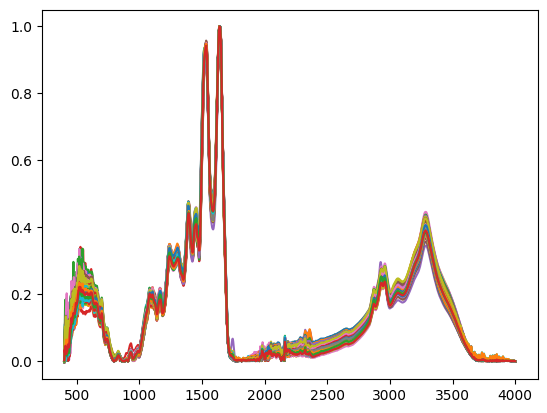

In [63]:
domain = pd.read_csv("../data/domain.csv").to_numpy().reshape(1, -1)[0]
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=1)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

In [53]:
def corr_plot(X, y):
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.3f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
    else:
        text = f"$R = {r:.3f}$\n$p = {p_val:.5f}$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
        
    plt.scatter(X, y, facecolor='w', edgecolor='k')
    plt.plot(x_range, predicted, color='r', linewidth=1.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    plt.text(text_x, text_y, text, verticalalignment='top')

In [54]:
def get_secondary_structure(areas_df):
    intermol_beta_sheet = areas_df['1611-1614'] + areas_df['1616-1619'] + areas_df['1622-1626']
    beta_sheet = areas_df['1627-1630'] + areas_df['1631-1634'] + areas_df['1635-1638'] + areas_df['1639-1641']
    random_coil = areas_df['1643-1646'] + areas_df['1646-1649']
    alpha_helix = areas_df['1650-1654'] + areas_df['1655-1657']
    beta_turn = (areas_df['1659-1663'] + areas_df['1665-1670'] + 
                 areas_df['1672-1675'] + areas_df['1678-1680'] + 
                 areas_df['1681-1685'] + areas_df['1686-1689'] +
                 areas_df['1693-1696'] + areas_df['1698-1700']
                )
    result = {
        "intermol beta sheet": intermol_beta_sheet,
        "beta sheet": beta_sheet,
        "random coil": random_coil,
        "alpha helix": alpha_helix,
        "beta turn": beta_turn
    }
    
    return result

In [66]:
def make_plot(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    
    plt.figure(figsize=(8, 5))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma', 'amplitude', 'eta']], 0)
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)

    #plt.plot(x_values, y_values, color='r')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    #plt.ylim([0, 1.1])
    plt.xlabel("Хвильове число")

def make_plot_amide(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    added_labels = {}
    
    plt.figure(figsize=(6.5, 4))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma', 'amplitude', 'eta']], 0)
        peak = x_values[np.argmax(y_pred)]

        if 1610 < peak < 1627:
            color = 'blue'
            label = r'Intermolecular $\beta$-sheet'
        elif 1628 < peak < 1642:
            color = 'green'
            label = r'$\beta$-sheet'
        elif 1643 < peak < 1650:
            color = 'red'
            label = r'Random coil'
        elif 1650 < peak < 1659:
            color = 'orange'
            label = r'$\alpha$-helix and Gln side chain'
        elif 1659 < peak < 1700:
            color = 'purple'
            label = r'$\beta$-turn'
        else:
            color = 'black'
            label = None

        if label and label not in added_labels:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1, label=label)
            added_labels[label] = True
        else:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1)
        
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)
    
    #plt.plot(x_values, y_values, color='b')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    plt.ylim([0, 1.1])
    plt.legend(fontsize=8)
    plt.xlabel("Хвильове число")

In [67]:
params = pd.read_csv("../data/fits/fit_1500_1700/101_pseudo_voigt_fit_5.0.csv").iloc[:, 1:]
params

,peak_found,wavenumber,gamma,amplitude,eta,FWHM,area,delta
0,1012.46200,1013.99979,13.40656,0.10259,0.99736,13.84540,0.00039,-1.53779
1,1028.85400,1028.86737,9.77029,0.11454,0.01478,10.12400,0.00042,-0.01337
2,1047.65700,1049.90094,12.48477,0.10250,0.91378,13.01700,0.00039,-2.24394
3,1050.06700,1052.49345,50.27725,4.25560,1.00000,50.62300,0.01625,-2.42645
4,1082.37000,1084.24414,35.28203,4.96892,0.47278,35.53481,0.01839,-1.87414
...,...,...,...,...,...,...,...,...
60,1679.24000,1679.48719,8.46159,1.49220,0.39652,8.67800,0.00554,-0.24719
61,1683.09700,1682.97946,5.03024,0.43102,0.02722,5.30400,0.00159,0.11754
62,1687.43600,1687.94493,11.12839,2.27889,0.16429,11.57100,0.00785,-0.50893
63,1694.66800,1694.26925,7.37396,0.62993,0.00013,7.71400,0.00206,0.39875


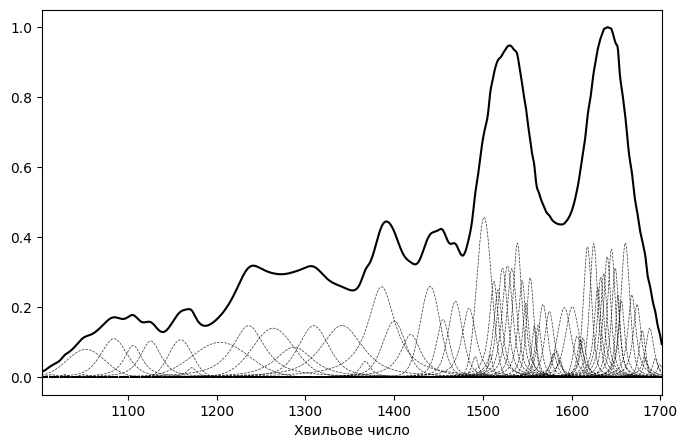

In [68]:
make_plot(x_values, params)